In [1]:
import importlib
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

from sccoda.util import comp_ana as mod
from sccoda.util import cell_composition_data as dat
from sccoda.util import data_visualization as viz



2023-09-21 15:14:21.615234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib
2023-09-21 15:14:21.615273: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
## https://stackoverflow.com/a/70106921


In [2]:
data = pd.read_table('../outputs/myeloids/myeloids_composition_table.txt', sep = '\t')

In [3]:
data.head()

,individual,stage,Classical-1,Classical-2,Intermediate-1,Intermediate-3,Non-classical,Intermediate-2,Classical-3,Unknown-1,Unknown-2,Classical-4,Unknown-3,Unknown-4,Myeloid dendritic,Classical-5,Classical-6,Unknown-5,Unknown-6,Unknown-7
0,1,Pre,193,105,2,32,8,12,12,15,31,7,20,11,5,5,0,14,7,4
1,1,Post,206,110,0,73,18,32,26,69,282,4,48,182,16,24,4,15,40,6
2,3,Pre,328,146,3,22,10,8,107,53,32,9,74,9,12,22,2,6,12,3
3,3,Post,598,258,3,169,120,64,151,104,42,36,90,11,14,47,7,13,16,32
4,4,Pre,871,703,8,66,22,29,68,71,14,22,30,12,32,14,9,25,5,2


In [4]:
data = pd.read_table('../outputs/bcells/bcell_composition_table.txt', sep = '\t')

In [5]:
data.head()

,individual,stage,Iga,Naive,Non-switched classical memory,Switched classical memory,Naive/transitional,Transitional,DN2
0,R1,Post,Non-IgA,348,59,87,85,26,18
1,R1,Pre,Non-IgA,475,72,133,114,38,18
2,R10,Post,Non-IgA,160,55,43,57,30,6
3,R10,Pre,Non-IgA,269,92,115,89,37,16
4,R13,Post,Non-IgA,163,3,22,30,15,2


In [6]:
data = dat.from_pandas(data, covariate_columns=['individual', 'stage', 'Iga'])

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

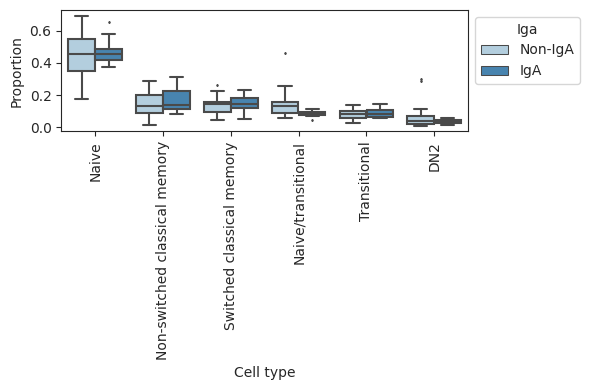

In [7]:
viz.boxplots(data, feature_name='Iga')

In [8]:
model = mod.CompositionalAnalysis(data, formula='stage + Iga')

Automatic reference selection! Reference cell type set to Transitional


2023-09-21 15:14:31.140539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/lib/R/lib
2023-09-21 15:14:31.140572: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-21 15:14:31.140593: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (8f1ebc9e1793): /proc/driver/nvidia/version does not exist
2023-09-21 15:14:31.140879: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [66]:
## https://github.com/theislab/scCODA/issues/33#issuecomment-855614614
## acceptance rate ideally >35%

In [9]:
sim_results = model.sample_hmc()

2023-09-21 15:15:07.963050: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-09-21 15:15:08.745189: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x7f72e80e90c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-09-21 15:15:08.745241: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
  0%|                                                                                                                                                                                      | 0/20000 [00:00<?, ?it/s]2023-09-21 15:15:08.810794: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-21 15:15:10.063871: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line i

MCMC sampling finished. (127.202 sec)
Acceptance rate: 74.5%


In [14]:
sim_results.summary()
print(sim_results.credible_effects())


Compositional Analysis summary:

Data: 36 samples, 6 cell types
Reference index: 4
Formula: stage + Iga

Intercepts:
                               Final Parameter  Expected Sample
Cell Type                                                      
Naive                                    2.631       266.240069
Non-switched classical memory            1.509        86.695191
Switched classical memory                1.425        79.710269
Naive/transitional                       1.227        65.391901
Transitional                             0.979        51.029220
DN2                                      0.424        29.294460


Effects:
                                              Final Parameter  \
Covariate      Cell Type                                        
stage[T.Pre]   Naive                                 0.000000   
               Non-switched classical memory         0.000000   
               Switched classical memory             0.000000   
               Naive/transitional  

In [11]:
sim_results.set_fdr(est_fdr=0.2)
print(sim_results.credible_effects())

Covariate       Cell Type                    
stage[T.Pre]    Naive                            False
                Non-switched classical memory    False
                Switched classical memory        False
                Naive/transitional               False
                Transitional                     False
                DN2                              False
Iga[T.Non-IgA]  Naive                            False
                Non-switched classical memory    False
                Switched classical memory        False
                Naive/transitional               False
                Transitional                     False
                DN2                              False
Name: Final Parameter, dtype: bool


In [12]:
sim_results.set_fdr(est_fdr=0.4)
print(sim_results.credible_effects())

Covariate       Cell Type                    
stage[T.Pre]    Naive                            False
                Non-switched classical memory    False
                Switched classical memory        False
                Naive/transitional               False
                Transitional                     False
                DN2                              False
Iga[T.Non-IgA]  Naive                            False
                Non-switched classical memory     True
                Switched classical memory        False
                Naive/transitional                True
                Transitional                     False
                DN2                              False
Name: Final Parameter, dtype: bool


In [15]:
sim_results.set_fdr(est_fdr=0.05)
sim_results.summary()

Compositional Analysis summary:

Data: 36 samples, 6 cell types
Reference index: 4
Formula: stage + Iga

Intercepts:
                               Final Parameter  Expected Sample
Cell Type                                                      
Naive                                    2.631       266.240069
Non-switched classical memory            1.509        86.695191
Switched classical memory                1.425        79.710269
Naive/transitional                       1.227        65.391901
Transitional                             0.979        51.029220
DN2                                      0.424        29.294460


Effects:
                                              Final Parameter  \
Covariate      Cell Type                                        
stage[T.Pre]   Naive                                      0.0   
               Non-switched classical memory              0.0   
               Switched classical memory                  0.0   
               Naive/transitional  

In [17]:
sim_results.effect_df.to_csv('../outputs/bcells/scCODA_bcells_df.csv')

In [20]:
sim_results.save('../outputs/myeloids/scCODA_granular.pickle')

In [16]:
sim_results.effect_df

Final Parameter  HDI 3%  \
Covariate      Cell Type                                                
stage[T.Pre]   Naive                                      0.0  -0.215   
               Non-switched classical memory              0.0  -0.214   
               Switched classical memory                  0.0  -0.203   
               Naive/transitional                         0.0  -0.244   
               Transitional                               0.0   0.000   
               DN2                                        0.0  -0.306   
Iga[T.Non-IgA] Naive                                      0.0  -0.423   
               Non-switched classical memory              0.0  -0.518   
               Switched classical memory                  0.0  -0.347   
               Naive/transitional                         0.0  -0.077   
               Transitional                               0.0   0.000   
               DN2                                        0.0  -0.289   

                                              HDI 97%     SD  \
Covariate      Cell Type                                       
stage[T.Pre]   Naive                            0.111  0.046   
               Non-switched classical memory    0.241  0.067   
               Switched classical memory        0.260  0.068   
               Naive/transitional               0.212  0.067   
               Transitional                     0.000  0.000   
               DN2                              0.320  0.096   
Iga[T.Non-IgA] Naive                            0.101  0.132   
               Non-switched classical memory    0.128  0.159   
               Switched classical memory        0.286  0.111   
               Naive/transitional               0.615  0.192   
               Transitional                     0.000  0.000   
               DN2                              0.435  0.125   

                                              Inclusion probability  \
Covariate      Cell Type                                              
stage[T.Pre]   Naive                                       0.273800   
               Non-switched classical memory               0.337800   
               Switched classical memory                   0.323133   
               Naive/transitional                          0.337800   
               Transitional                                0.000000   
               DN2                                         0.395000   
Iga[T.Non-IgA] Naive                                       0.557200   
               Non-switched classical memory               0.573333   
               Switched classical memory                   0.455533   
               Naive/transitional                          0.633067   
               Transitional                                0.000000   
               DN2                                         0.419733   

                                              Expected Sample  \
Covariate      Cell Type                                        
stage[T.Pre]   Naive                               266.240069   
               Non-switched classical memory        86.695191   
               Switched classical memory            79.710269   
               Naive/transitional                   65.391901   
               Transitional                         51.029220   
               DN2                                  29.294460   
Iga[T.Non-IgA] Naive                               266.240069   
               Non-switched classical memory        86.695191   
               Switched classical memory            79.710269   
               Naive/transitional                   65.391901   
               Transitional                         51.029220   
               DN2                                  29.294460   

                                              log2-fold change  
Covariate      Cell Type                                        
stage[T.Pre]   Naive                                       0.0  
               Non-switch

In [ ]:
## same thing for coarse

In [40]:
data = pd.read_table('../outputs/myeloids/myeloids_composition_table.txt', sep = '\t')
data_coarse = data.copy()
data_coarse['classical'] = data_coarse[[col for col in data_coarse.columns if col.startswith('Classical')]].sum(axis=1)
data_coarse['intermediate'] = data_coarse[[col for col in data_coarse.columns if col.startswith('Intermediate')]].sum(axis=1)
data_coarse = data_coarse[data_coarse.columns.drop(list(data_coarse.filter(regex='Classical-')))]
data_coarse = data_coarse[data_coarse.columns.drop(list(data_coarse.filter(regex='Intermediate-')))]

In [41]:
data_coarse.head()


,individual,stage,Non-classical,Unknown-1,Unknown-2,Unknown-3,Unknown-4,Myeloid dendritic,Unknown-5,Unknown-6,Unknown-7,classical,intermediate
0,1,Pre,8,15,31,20,11,5,14,7,4,322,46
1,1,Post,18,69,282,48,182,16,15,40,6,374,105
2,3,Pre,10,53,32,74,9,12,6,12,3,614,33
3,3,Post,120,104,42,90,11,14,13,16,32,1097,236
4,4,Pre,22,71,14,30,12,32,25,5,2,1687,103


In [42]:
data.head()

,individual,stage,Classical-1,Classical-2,Intermediate-1,Intermediate-3,Non-classical,Intermediate-2,Classical-3,Unknown-1,Unknown-2,Classical-4,Unknown-3,Unknown-4,Myeloid dendritic,Classical-5,Classical-6,Unknown-5,Unknown-6,Unknown-7
0,1,Pre,193,105,2,32,8,12,12,15,31,7,20,11,5,5,0,14,7,4
1,1,Post,206,110,0,73,18,32,26,69,282,4,48,182,16,24,4,15,40,6
2,3,Pre,328,146,3,22,10,8,107,53,32,9,74,9,12,22,2,6,12,3
3,3,Post,598,258,3,169,120,64,151,104,42,36,90,11,14,47,7,13,16,32
4,4,Pre,871,703,8,66,22,29,68,71,14,22,30,12,32,14,9,25,5,2


In [45]:
data_coarse.sum(axis=1) == data.sum(axis=1)

0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
dtype: bool

In [47]:
data_coarse = dat.from_pandas(data_coarse, covariate_columns=['individual', 'stage'])

AttributeError: 'AnnData' object has no attribute 'loc'

<AxesSubplot:xlabel='Cell type', ylabel='Proportion'>

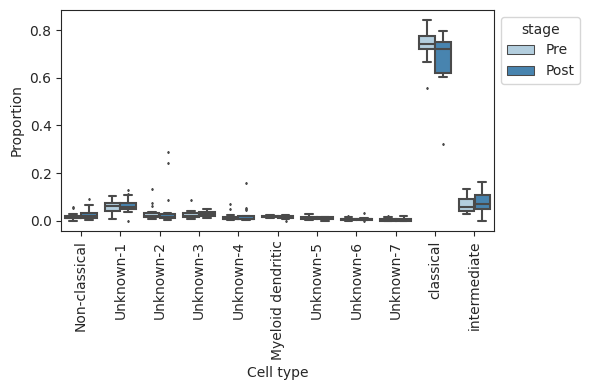

In [65]:
viz.boxplots(data_coarse, feature_name='stage')

In [81]:
model_coarse = mod.CompositionalAnalysis(data_coarse, formula='stage + (1|individual)')

Automatic reference selection! Reference cell type set to Myeloid dendritic
Zero counts encountered in data! Added a pseudocount of 0.5.


In [82]:
sim_results_coarse = model_coarse.sample_hmc(num_results =50000, num_burnin = 10000, step_size = 0.02)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:25<00:00, 188.64it/s]


MCMC sampling finished. (321.044 sec)
Acceptance rate: 37.9%


In [83]:
sim_results_coarse.summary_extended()

Compositional Analysis summary (extended):

Data: 36 samples, 11 cell types
Reference index: 5
Formula: stage + (1|individual)
Spike-and-slab threshold: 0.970

MCMC Sampling: Sampled 50000 chain states (10000 burnin samples) in 321.044 sec. Acceptance rate: 37.9%

Intercepts:
                   Final Parameter  HDI 3%  HDI 97%     SD  Expected Sample
Cell Type                                                                  
Non-classical                0.722   0.361    0.978  0.181        62.928922
Unknown-1                    1.655   1.437    1.885  0.166       159.973130
Unknown-2                    0.856   0.626    1.190  0.176        71.952477
Unknown-3                    0.954   0.681    1.292  0.206        79.360905
Unknown-4                    0.417   0.140    0.704  0.158        46.386379
Myeloid dendritic            0.572   0.384    0.821  0.145        54.163425
Unknown-5                    0.247  -0.132    0.545  0.248        39.134556
Unknown-6                   -0.025  -0.

In [70]:
print(sim_results_coarse.credible_effects())

Covariate     Cell Type        
stage[T.Pre]  Non-classical        False
              Unknown-1            False
              Unknown-2            False
              Unknown-3            False
              Unknown-4            False
              Myeloid dendritic    False
              Unknown-5            False
              Unknown-6            False
              Unknown-7            False
              classical             True
              intermediate         False
individual    Non-classical        False
              Unknown-1            False
              Unknown-2            False
              Unknown-3            False
              Unknown-4            False
              Myeloid dendritic    False
              Unknown-5            False
              Unknown-6            False
              Unknown-7            False
              classical            False
              intermediate         False
Name: Final Parameter, dtype: bool


In [58]:
sim_results_coarse.save('../outputs/myeloids/scCODA_coarse.pickle')

In [78]:
sim_results_coarse.effect_df.to_csv('../outputs/myeloids/scCODA_coarse_df.csv')